# Composite Trotter-QDrift Simulator With Optimized Partitioning

> The number of gates required for trotter decomposition is exponential toward the length of the hamiltonian, while the number of gates for qDrift decomposition is largely dependent on $\lambda$ or the spectral norm. This composite method offers drastic improvments because we can partition the hamiltonian up favourably for these two methods, significantly reducing the number of gates required. This will allow for the simulation of quantum systems to be more practical for implementation on NISQ and ISQ hardware.

## Our Imports

In [14]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import QDrift, SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper, LinearMapper
from qiskit_nature.second_q.hamiltonians.heisenberg_model import HeisenbergModel
from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition


## Lets Get Our Molecular Hamiltonians

In [16]:
h2_driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735", 
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g')

h2_hamiltonian = JordanWignerMapper().map(h2_driver.run().hamiltonian.second_q_op()).simplify(atol=0)

## Lets Get Our Transverse-Ising Hamiltonian

In [17]:
# Transverse-Ising Model
line_lattice = LineLattice(num_nodes=2, boundary_condition=BoundaryCondition.PERIODIC)
ti_model = HeisenbergModel(line_lattice, (1.0, 0.0, 0.0), (0.0, 0.0, 1.0))


ti_hamiltonian = LinearMapper().map(ti_model.second_q_op()).simplify(atol=0)

## Genetic Algorithm Search For Partitioning

The number of gates required for trotter decomposition is exponential toward the length of the hamiltonian, while the number of gates for qdrift decomposition is largely dependent on $\lambda$ or the spectral norm. The composite method may offer improvemnts because we can partition the hamiltonian up favourably for these two methods, producing a less resource intensive quantum simulation method. This will allow it to be more practical for implementation on NISQ and ISQ hardware.

We use a genetic algorithm to search for a near-optimal partitioning of the hamilonian H into two hamiltonians for the Trotter and QDrift Channels. We partition H into two parts $H=A+B$ where A is the hamiltonian for the Trotter Channel $U_A(t)$ and QDrift Channel $U_B(t;N,M)$ We can define the total channel as $U_H(t) = U_A(t) \circ U_B(t; N,M)$

The cost or total number of gates for this composite channel is defined as
$$C_{cost} \leq (L_A+N_B)\frac{t^2}{\epsilon}\left(\sum_{i<j}a_ia_j||[A_i, A_j]||+\frac{1}{2}\sum_{ij}a_ib_j||[A_i,B_j]||+\frac{2\lambda^2}{N_B}\right)$$

We use this cost function as the fitness function in our genetic algorithm, and create partitions using the chromosomes


In [23]:
from genetic import run_genetic_algo

# First for H2
# Small hamiltonian and not too hard to optimize so we do a population size of 100 for 10 generations with an arbitrary t and e
h2_least_cost, h2_h_trotter, h2_h_qdrift = run_genetic_algo(population_size=100,num_generations=10,elite_prop=0.1,hamiltonian=h2_hamiltonian, N_b=200,e=1e-3,t=1,mutate_prob=0.1)

Generation 1 Lowest Number of Gates: 11480.0
Generation 2 Lowest Number of Gates: 11070.0
Generation 3 Lowest Number of Gates: 3690.0
Generation 4 Lowest Number of Gates: 2678.0
Generation 5 Lowest Number of Gates: 2678.0
Generation 6 Lowest Number of Gates: 2678.0
Generation 7 Lowest Number of Gates: 2070.0
Generation 8 Lowest Number of Gates: 2070.0
Generation 9 Lowest Number of Gates: 2070.0
Generation 10 Lowest Number of Gates: 2070.0
Lowest Number of Gates: 2070.0


In [32]:
# Now for Transverse-Ising
# Small hamiltonian and not too hard to optimize so we do a population size of 100 for 10 generations with an arbitrary t and e
ti_least_cost, ti_h_trotter, ti_h_qdrift = run_genetic_algo(population_size=100,num_generations=10,elite_prop=0.1,hamiltonian=ti_hamiltonian, N_b=200,e=1e-3,t=1,mutate_prob=0.1)

Generation 1 Lowest Number of Gates: 41820.0
Generation 2 Lowest Number of Gates: 17340.0
Generation 3 Lowest Number of Gates: 5075.0
Generation 4 Lowest Number of Gates: 5075.0
Generation 5 Lowest Number of Gates: 5075.0
Generation 6 Lowest Number of Gates: 4692.0
Generation 7 Lowest Number of Gates: 4692.0
Generation 8 Lowest Number of Gates: 4692.0
Generation 9 Lowest Number of Gates: 4692.0
Generation 10 Lowest Number of Gates: 4692.0
Lowest Number of Gates: 4692.0


For larger hamiltonians we would require a larger population size and more generations

## Number of Gates vs Error

In [25]:
from composite import Composite
from qiskit.synthesis import QDrift, SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from util import calc_reps_qdrift, calc_reps_trotter

errors = [10.0**(-1*x) for x in range(1,11)]

h2_evo_h = PauliEvolutionGate(h2_hamiltonian, time=2)
ti_evo_h = PauliEvolutionGate(ti_hamiltonian, time=2)

h2_trotter_gate_counts = []
h2_qdrift_gate_counts = []
h2_composite_gate_counts = []

ti_trotter_gate_counts = []
ti_qdrift_gate_counts = []
ti_composite_gate_counts = []

for error in errors:
    trotter_circ = SuzukiTrotter(reps=1).synthesize(h2_evo_h)
    qdrift_circ = QDrift(reps=1).synthesize(h2_evo_h)
    
    composite_circ = Composite(h2_h_trotter,h2_h_qdrift, t=2, N_b=200, error=error)
    composite_circ.synthesize(need_reps=False)

    h2_trotter_gate_counts.append(sum(dict(trotter_circ.count_ops()).values())*calc_reps_trotter(error, h2_hamiltonian, 2))
    h2_qdrift_gate_counts.append(sum(dict(qdrift_circ.count_ops()).values())*calc_reps_qdrift(error,h2_hamiltonian,2))

    h2_composite_gate_counts.append(composite_circ.count_gates(multiply_reps=True))
    
    print(f"H2 Error={error} -> Trotter Gate Count: {h2_trotter_gate_counts[-1]}, qDrift Gate Count: {h2_qdrift_gate_counts[-1]}, Composite Gate Counts: {h2_composite_gate_counts[-1]}")

for error in errors:
    trotter_circ = SuzukiTrotter(reps=1).synthesize(ti_evo_h)
    qdrift_circ = QDrift(reps=1).synthesize(ti_evo_h)
    
    composite_circ = Composite(ti_h_trotter,ti_h_qdrift, t=2, N_b=200, error=error)
    composite_circ.synthesize(need_reps=False)

    ti_trotter_gate_counts.append(sum(dict(trotter_circ.count_ops()).values())*calc_reps_trotter(error, ti_hamiltonian, 2))
    ti_qdrift_gate_counts.append(sum(dict(qdrift_circ.count_ops()).values())*calc_reps_qdrift(error,ti_hamiltonian,2))

    ti_composite_gate_counts.append(composite_circ.count_gates(multiply_reps=True))

    print(f"Transverse-Ising Error={error} -> Trotter Gate Count: {ti_trotter_gate_counts[-1]}, qDrift Gate Count: {ti_qdrift_gate_counts[-1]}, Composite Gate Counts: {ti_composite_gate_counts[-1]}")


H2 Error=0.1 -> Trotter Gate Count: 86449, qDrift Gate Count: 34574, Composite Gate Counts: 1613
H2 Error=0.01 -> Trotter Gate Count: 858081, qDrift Gate Count: 345386, Composite Gate Counts: 1652
H2 Error=0.001 -> Trotter Gate Count: 8574401, qDrift Gate Count: 3453742, Composite Gate Counts: 2107
H2 Error=0.0001 -> Trotter Gate Count: 85737659, qDrift Gate Count: 34537420, Composite Gate Counts: 6566
H2 Error=1e-05 -> Trotter Gate Count: 857370094, qDrift Gate Count: 345374141, Composite Gate Counts: 51221
H2 Error=1e-06 -> Trotter Gate Count: 8573694502, qDrift Gate Count: 3453740879, Composite Gate Counts: 497771
H2 Error=1e-07 -> Trotter Gate Count: 85736938466, qDrift Gate Count: 34537408318, Composite Gate Counts: 4963193
H2 Error=1e-08 -> Trotter Gate Count: 857369378251, qDrift Gate Count: 345374082649, Composite Gate Counts: 49617413
H2 Error=1e-09 -> Trotter Gate Count: 8573693775956, qDrift Gate Count: 3453740826490, Composite Gate Counts: 496159639
H2 Error=1e-10 -> Trotte

## Lets Plot!

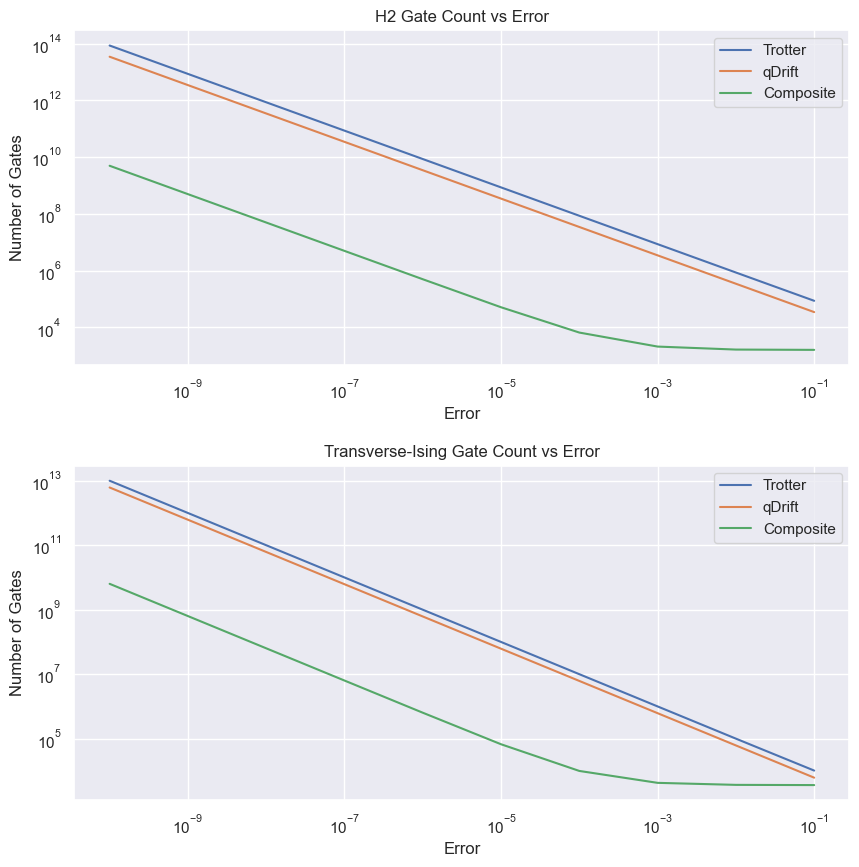

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, (ax0, ax1) = plt.subplots(2)
fig.set_size_inches(10,10)
plt.subplots_adjust(hspace=0.3)

ax0.plot(errors,h2_trotter_gate_counts,label='Trotter')
ax0.plot(errors, h2_qdrift_gate_counts,label='qDrift')
ax0.plot(errors, h2_composite_gate_counts,label='Composite')
ax0.set_xlabel('Error')
ax0.set_ylabel('Number of Gates')
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_title('H2 Gate Count vs Error')
ax0.legend()

ax1.plot(errors,ti_trotter_gate_counts,label='Trotter')
ax1.plot(errors, ti_qdrift_gate_counts,label='qDrift')
ax1.plot(errors, ti_composite_gate_counts,label='Composite')
ax1.set_xlabel('Error')
ax1.set_ylabel('Number of Gates')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Transverse-Ising Gate Count vs Error')
ax1.legend()
plt.show()

Here we look at the scaling of the number of gates required against error for these 3 methods. As you can see there is a clear improvment with our composite trotter-qDrift method for both H2 and Transverse-Ising models. It is also important to notice that qDrift does worse than trotter on the H2 task, but better on the Transverse-Ising task. Trotter and qDrift each have their own advantages, and our composite method combines the best of both worlds.

## Number of Gates vs Time
Now lets look at how the number of gates scales against time for these three methods

In [30]:
from composite import Composite
from qiskit.synthesis import QDrift, SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from util import calc_reps_qdrift, calc_reps_trotter

error = 1e-3
times = [10*x for x in range(1,11)]

h2_evo_h = PauliEvolutionGate(h2_hamiltonian, time=2)
ti_evo_h = PauliEvolutionGate(ti_hamiltonian, time=2)

h2_trotter_gate_counts = []
h2_qdrift_gate_counts = []
h2_composite_gate_counts = []

ti_trotter_gate_counts = []
ti_qdrift_gate_counts = []
ti_composite_gate_counts = []

for time in times:
    trotter_circ = SuzukiTrotter(reps=1).synthesize(h2_evo_h)
    qdrift_circ = QDrift(reps=1).synthesize(h2_evo_h)
    
    composite_circ = Composite(h2_h_trotter,h2_h_qdrift, t=time, N_b=200, error=error)
    composite_circ.synthesize(need_reps=False)

    h2_trotter_gate_counts.append(sum(dict(trotter_circ.count_ops()).values())*calc_reps_trotter(error, h2_hamiltonian, time))
    h2_qdrift_gate_counts.append(sum(dict(qdrift_circ.count_ops()).values())*calc_reps_qdrift(error,h2_hamiltonian,time))

    h2_composite_gate_counts.append(composite_circ.count_gates(multiply_reps=True))
    print(f"H2 Time={time} -> Trotter Gate Count: {h2_trotter_gate_counts[-1]}, qDrift Gate Count: {h2_qdrift_gate_counts[-1]}, Composite Gate Counts: {h2_composite_gate_counts[-1]}")

for time in times:
    trotter_circ = SuzukiTrotter(reps=1).synthesize(ti_evo_h)
    qdrift_circ = QDrift(reps=1).synthesize(ti_evo_h)
    
    composite_circ = Composite(ti_h_trotter,ti_h_qdrift, t=time, N_b=200, error=error)
    composite_circ.synthesize(need_reps=False)

    ti_trotter_gate_counts.append(sum(dict(trotter_circ.count_ops()).values())*calc_reps_trotter(error, ti_hamiltonian, time))
    ti_qdrift_gate_counts.append(sum(dict(qdrift_circ.count_ops()).values())*calc_reps_qdrift(error,ti_hamiltonian,time))

    ti_composite_gate_counts.append(composite_circ.count_gates(multiply_reps=True))
    print(f"Transverse-Ising Time={time} -> Trotter Gate Count: {ti_trotter_gate_counts[-1]}, qDrift Gate Count: {ti_qdrift_gate_counts[-1]}, Composite Gate Counts: {ti_composite_gate_counts[-1]}")

H2 Time=10 -> Trotter Gate Count: 214345873, qDrift Gate Count: 86343550, Composite Gate Counts: 50615
H2 Time=20 -> Trotter Gate Count: 857376445, qDrift Gate Count: 345374141, Composite Gate Counts: 202421
H2 Time=30 -> Trotter Gate Count: 1929091687, qDrift Gate Count: 777091714, Composite Gate Counts: 455244
H2 Time=40 -> Trotter Gate Count: 3429491628, qDrift Gate Count: 1381496387, Composite Gate Counts: 809271
H2 Time=50 -> Trotter Gate Count: 5358576239, qDrift Gate Count: 2158588042, Composite Gate Counts: 1264302
H2 Time=60 -> Trotter Gate Count: 7716345578, qDrift Gate Count: 3108366797, Composite Gate Counts: 1820550
H2 Time=70 -> Trotter Gate Count: 10502799558, qDrift Gate Count: 4230832534, Composite Gate Counts: 2478002
H2 Time=80 -> Trotter Gate Count: 13717938266, qDrift Gate Count: 5525985371, Composite Gate Counts: 3236658
H2 Time=90 -> Trotter Gate Count: 17361761644, qDrift Gate Count: 6993825190, Composite Gate Counts: 4096331
H2 Time=100 -> Trotter Gate Count: 2

## Lets Plot

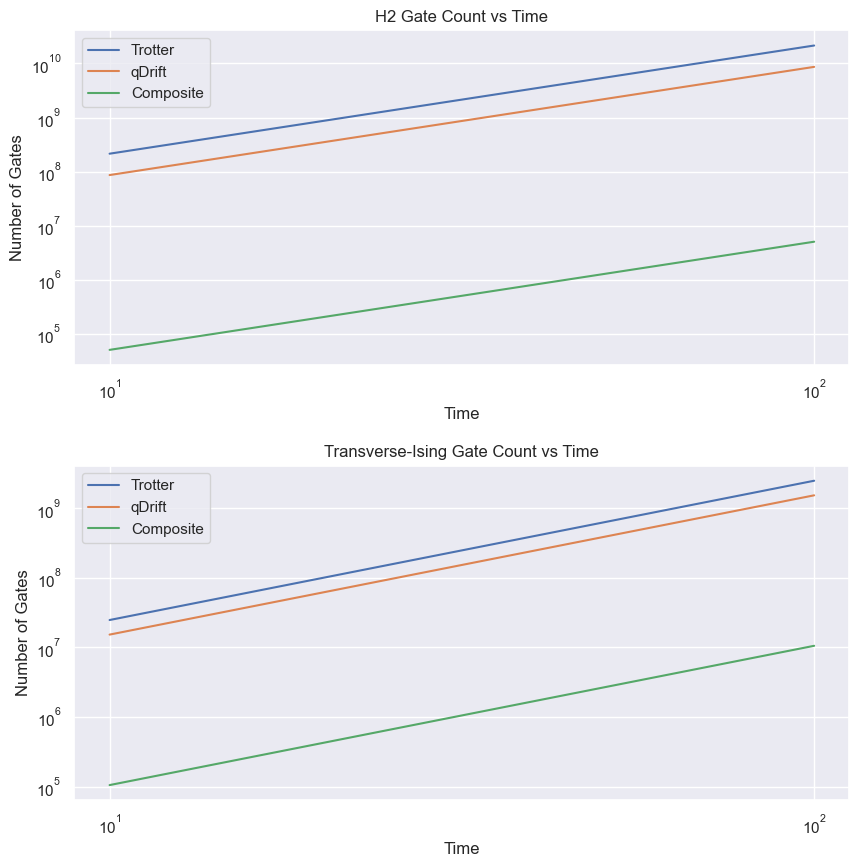

In [31]:
fig, (ax0, ax1) = plt.subplots(2)
fig.set_size_inches(10,10)
plt.subplots_adjust(hspace=0.3)

ax0.plot(times,h2_trotter_gate_counts,label='Trotter')
ax0.plot(times, h2_qdrift_gate_counts,label='qDrift')
ax0.plot(times, h2_composite_gate_counts,label='Composite')
ax0.set_xlabel('Time')
ax0.set_ylabel('Number of Gates')
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_title('H2 Gate Count vs Time')
ax0.legend()

ax1.plot(times,ti_trotter_gate_counts,label='Trotter')
ax1.plot(times, ti_qdrift_gate_counts,label='qDrift')
ax1.plot(times, ti_composite_gate_counts,label='Composite')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Gates')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Transverse-Ising Gate Count vs Time')
ax1.legend()
plt.show()

Once again we can see a significant improvment in the number of gates required with our composite method

## Circuit Visualization

Now lets see what one repetition of our trotter and qDrift channels look like in our composite method

In [48]:
visualize_composite_circ = Composite(ti_h_trotter,ti_h_qdrift, t=2, N_b=200, error=1e-3)
visualize_composite_circ.synthesize(need_reps=False)

Trotter Circuit!!:


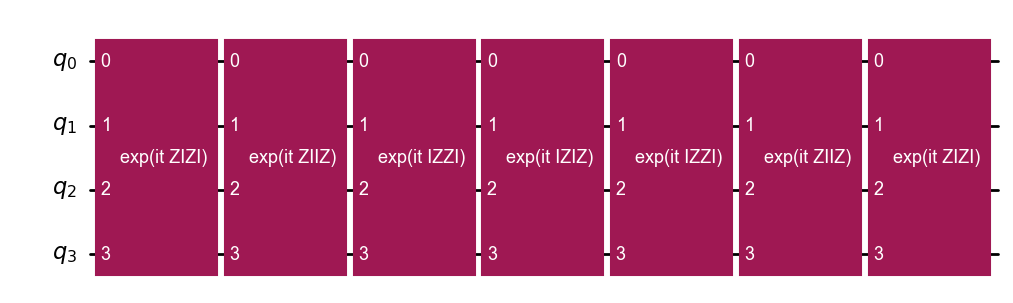

In [52]:
# Trotter Circuit
print('Trotter Circuit!!:')
visualize_composite_circ.trotter_circ.draw(output='mpl')

QDrift Circuit!!:


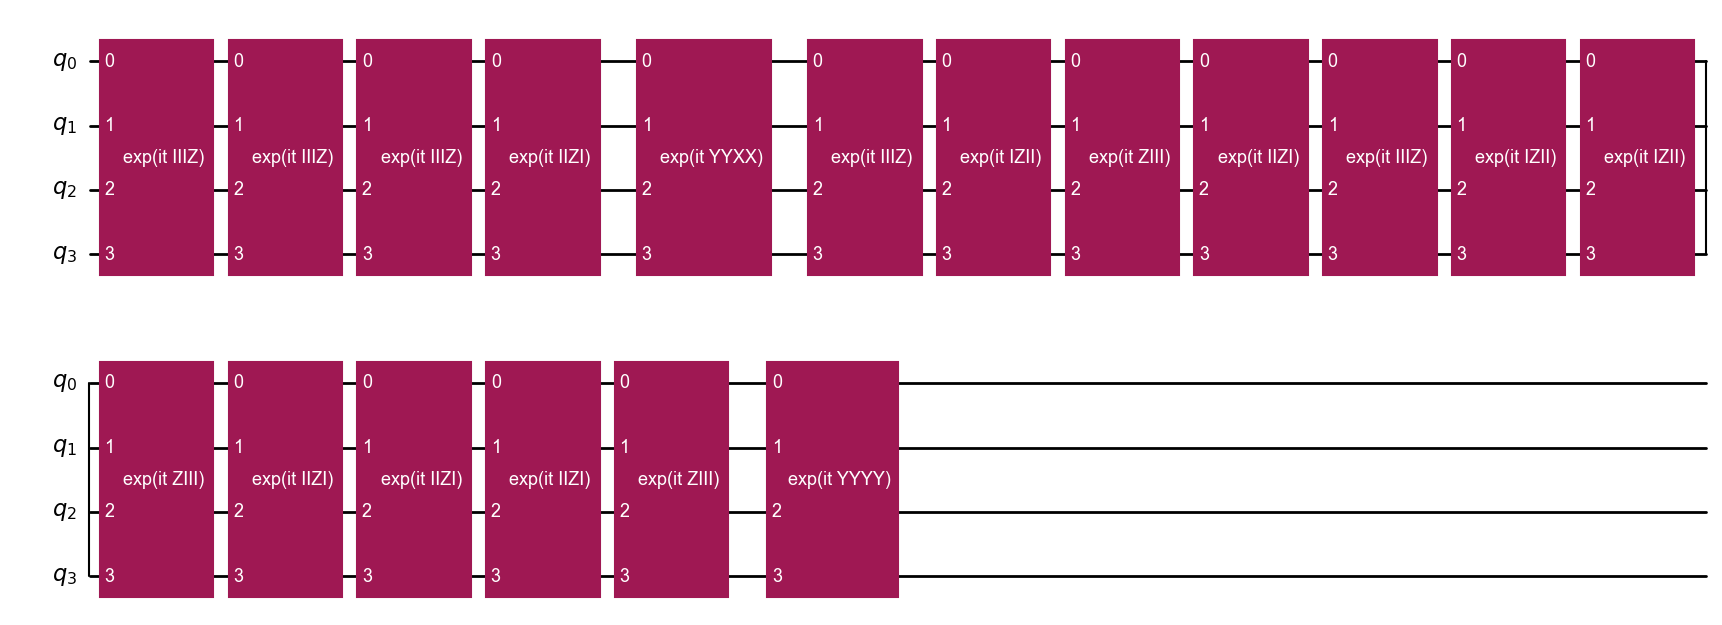

In [51]:
# QDrift Circuit
print('QDrift Circuit!!:')
visualize_composite_circ.qdrift_circ.draw(output='mpl')